In [1]:
!pip install pgmpy networkx numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.6 MB/s eta 0:00:00


Saving diabetes.csv to diabetes.csv


  0%|          | 0/1000000 [00:00<?, ?it/s]

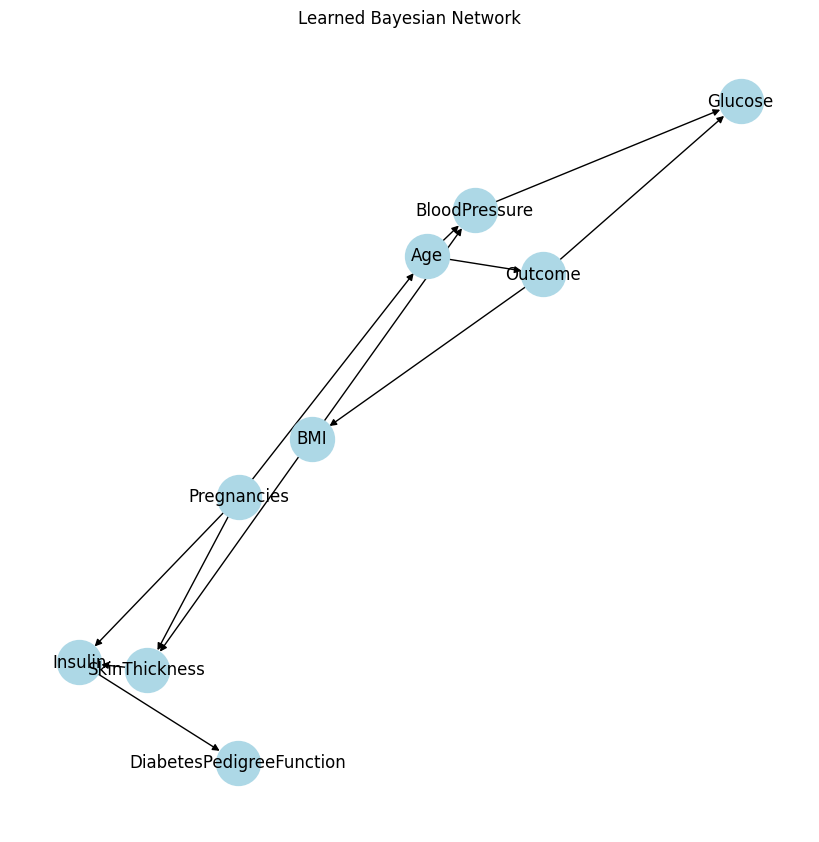

Full Network Accuracy: 1.0
Pruned Network Accuracy: 1.0


In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.inference.EliminationOrder import MinFill
from pgmpy.estimators import HillClimbSearch, BicScore
from networkx.algorithms import community as nx_community
import random
import time

# Load and preprocess dataset
from google.colab import files
uploaded = files.upload()
data = pd.read_csv('diabetes.csv')  # Replace with the correct uploaded filename
data = data.dropna()

# Binarize data
binary_data = (data > data.median()).astype(int)
binary_data['Outcome'] = data['Outcome']  # Keep original target variable as binary

# Functions for pruning
def prune_basic(model, query_node, evidence_nodes):
    relevant_nodes = set([query_node]) | set(evidence_nodes)
    for node in relevant_nodes.copy():
        relevant_nodes.update(nx.ancestors(nx.DiGraph(model.edges()), node))
    irrelevant_nodes = set(model.nodes()) - relevant_nodes
    pruned_model = model.copy()
    pruned_model.remove_nodes_from(irrelevant_nodes)
    return pruned_model, irrelevant_nodes

def prune_dynamic(model, query_node, evidence_nodes):
    pruned_model = model.copy()
    irrelevant_nodes = set()
    ancestors_query = nx.ancestors(nx.DiGraph(model.edges()), query_node)
    ancestors_evidence = set()
    for evidence_node in evidence_nodes:
        ancestors_evidence.update(nx.ancestors(nx.DiGraph(model.edges()), evidence_node))
    for node in model.nodes():
        if node != query_node and node not in evidence_nodes:
            node_ancestors = nx.ancestors(nx.DiGraph(model.edges()), node)
            if node_ancestors.isdisjoint({query_node}) and node_ancestors.isdisjoint(evidence_nodes):
                pruned_model.remove_node(node)
                irrelevant_nodes.add(node)
    return pruned_model, irrelevant_nodes

def prune_v_structure(model, query_var, evidence):
    pruned_model = model.copy()
    evidence_nodes = set(evidence.keys())
    nodes_to_keep = set([query_var] + list(evidence_nodes))

    for node in list(nodes_to_keep):
        ancestors = nx.ancestors(nx.DiGraph(model.edges()), node)
        nodes_to_keep.update(ancestors)

    irrelevant_nodes = set()
    for node in list(pruned_model.nodes()):
        if node in nodes_to_keep:
            continue
        parents = model.get_parents(node)
        if len(parents) > 1:
            children = model.get_children(node)
            if all(child not in nodes_to_keep for child in children):
                descendants = nx.descendants(nx.DiGraph(model.edges()), node)
                descendants = descendants - nodes_to_keep
                irrelevant_nodes.update(descendants)
                irrelevant_nodes.add(node)
                if node in pruned_model.nodes():
                    pruned_model.remove_node(node)
                pruned_model.remove_nodes_from([desc for desc in descendants if desc in pruned_model.nodes()])
    return pruned_model, irrelevant_nodes

def prune_separators(model, query_var, evidence):
    pruned_model = model.copy()
    nx_graph = nx.DiGraph(model.edges())
    separators = set()
    for node in list(nx_graph.nodes()):
        if node != query_var and node not in evidence:
            temp_graph = nx_graph.copy()
            temp_graph.remove_node(node)
            if not all(nx.has_path(temp_graph, query_var, ev) for ev in evidence):
                separators.add(node)
    for sep in list(separators):
        if sep in pruned_model.nodes():
            descendants = nx.descendants(nx_graph, sep)
            for desc in list(descendants):
                if desc in pruned_model.nodes() and desc != query_var:
                    pruned_model.remove_node(desc)
            if sep in pruned_model.nodes() and sep != query_var:
                pruned_model.remove_node(sep)
    return pruned_model, separators

def prune_clusters(model, query_var, evidence):
    pruned_model = model.copy()
    nx_graph = nx.Graph(model.edges())
    communities = list(nx_community.asyn_lpa_communities(nx_graph))
    query_community = None
    for community in communities:
        if query_var in community:
            query_community = community
            break
    nodes_to_keep = set(query_community) if query_community else set()
    nodes_to_remove = set(model.nodes()) - nodes_to_keep
    for node in nodes_to_remove:
        if node != query_var:
            pruned_model.remove_node(node)
    return pruned_model, nodes_to_keep

def query_pruned_network(pruned_model, query_var, full_evidence):
    if query_var not in pruned_model.nodes():
        raise ValueError(f"The query variable {query_var} was erroneously pruned.")
    pruned_evidence = {node: val for node, val in full_evidence.items() if node in pruned_model.nodes()}
    pruned_inference = VariableElimination(pruned_model)
    result_pruned = pruned_inference.query(variables=[query_var], evidence=pruned_evidence)
    return result_pruned

def visualize_network(model, title):
    nx_graph = nx.DiGraph(model.edges())
    pos = nx.spring_layout(nx_graph)
    plt.figure(figsize=(8, 8))
    nx.draw(nx_graph, pos, with_labels=True, node_size=1000, node_color='lightblue', edge_color='k', font_size=12)
    plt.title(title)
    plt.show()

def calculate_accuracy(predicted_probs, true_values):
    predicted = (predicted_probs > 0.5).astype(int)
    accuracy = np.mean(predicted == true_values)
    return accuracy

# Learn Bayesian Network using Greedy Hill Climb and BIC Score
train_data = binary_data.sample(frac=0.8, random_state=42)
test_data = binary_data.drop(train_data.index)

hc = HillClimbSearch(train_data)
model_structure = hc.estimate(scoring_method=BicScore(train_data))

# Convert DAG to Bayesian Network for inference
best_model = BayesianNetwork(model_structure.edges())
best_model.fit(train_data)
visualize_network(best_model, "Learned Bayesian Network")

# Perform inference and compare
query_var = 'Outcome'
evidence_vars = list(train_data.columns.drop(query_var))
true_outcomes = test_data[query_var].values
evidence = test_data[evidence_vars].iloc[:10].to_dict(orient='records')

# Full Network Inference
full_inference = VariableElimination(best_model)
full_preds = []

for ev in evidence:
    result = full_inference.query(variables=[query_var], evidence=ev)
    full_preds.append(result.values[1])  # Probability of class 1

# Pruned Network Inference
pruned_preds = []
pruned_model, _ = prune_v_structure(best_model, query_var, evidence[0])

for ev in evidence:
    result = query_pruned_network(pruned_model, query_var, ev)
    pruned_preds.append(result.values[1])  # Probability of class 1

# Compare Accuracy
full_accuracy = calculate_accuracy(np.array(full_preds), true_outcomes[:len(full_preds)])
pruned_accuracy = calculate_accuracy(np.array(pruned_preds), true_outcomes[:len(pruned_preds)])

print("Full Network Accuracy:", full_accuracy)
print("Pruned Network Accuracy:", pruned_accuracy)


Sample of evidence subsets with varying sizes:
[{'Glucose': 0, 'BMI': 0, 'Pregnancies': 0}, {'Pregnancies': 1, 'BloodPressure': 0, 'Glucose': 0}, {'DiabetesPedigreeFunction': 1, 'SkinThickness': 0, 'Pregnancies': 0}, {'Pregnancies': 1, 'DiabetesPedigreeFunction': 0, 'BloodPressure': 0}, {'BloodPressure': 1, 'Glucose': 1, 'Age': 1}, {'Insulin': 0, 'Glucose': 1, 'SkinThickness': 0}, {'Glucose': 1, 'SkinThickness': 1, 'Pregnancies': 0}, {'DiabetesPedigreeFunction': 1, 'SkinThickness': 1, 'Age': 1}, {'SkinThickness': 0, 'Insulin': 0, 'BloodPressure': 1}, {'Insulin': 1, 'DiabetesPedigreeFunction': 1, 'BMI': 1}]

Results with Varying Evidence Sizes:
Full Network Accuracy: 0.4
Average Full Network Inference Cost: 6.9
Pruned Network (V_structure):
  Accuracy: 0.4
  Average Inference Cost: 4.7


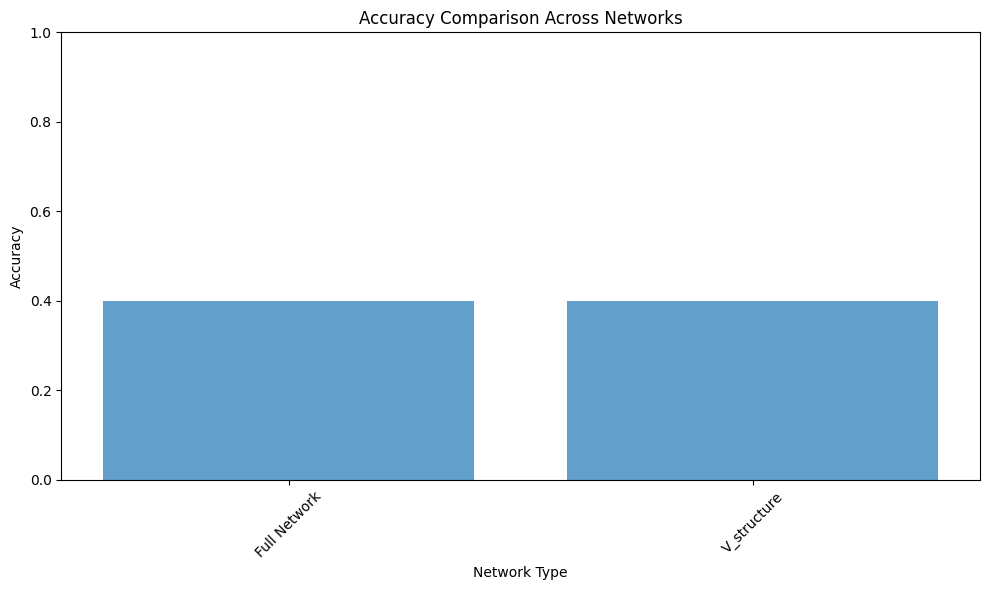

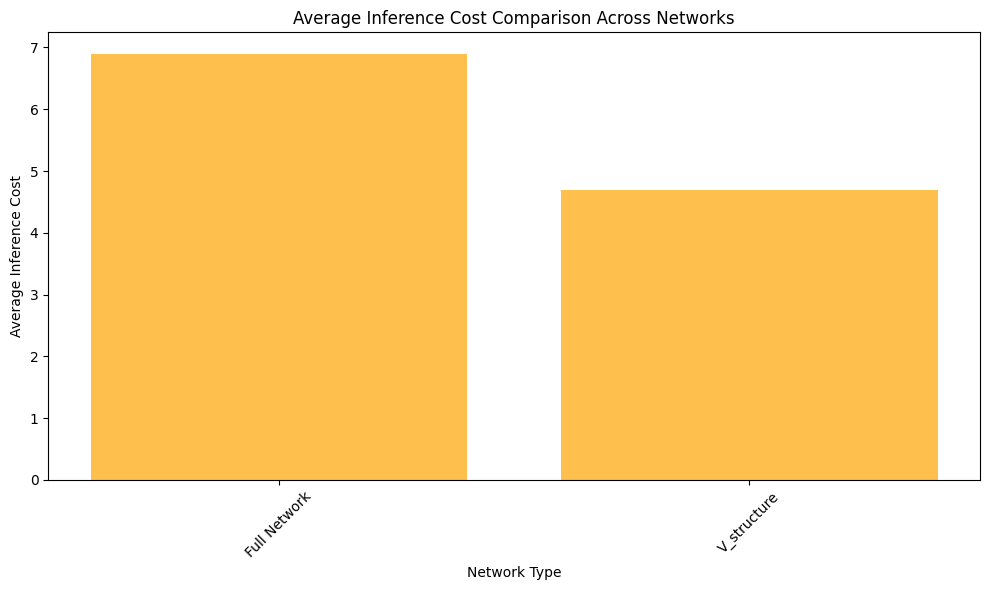

In [5]:
import numpy as np
from itertools import combinations

def generate_varying_evidence(data, query_var, num_samples, seed=42):
    """
    Generates subsets of evidence variables with varying sizes.
    Args:
    - data (pd.DataFrame): Dataset to select evidence from.
    - query_var (str): Variable to query (excluded from evidence).
    - num_samples (int): Number of varying evidence queries to generate.
    - seed (int): Random seed for reproducibility.

    Returns:
    - list[dict]: A list of dictionaries with varying numbers of evidence variables.
    """
    np.random.seed(seed)
    evidence_vars = list(data.columns.drop(query_var))
    varying_evidence = []
    for _ in range(num_samples):
        num_evidence = 3  # Random number of evidence variables
        chosen_vars = np.random.choice(evidence_vars, size=num_evidence, replace=False)
        evidence_row = data.sample(1).iloc[0][chosen_vars].to_dict()  # Random row as evidence
        varying_evidence.append(evidence_row)
    return varying_evidence

# Function to calculate inference cost
def calculate_cost(model, evidence):
    """
    Calculates the inference cost as the number of nodes involved in inference.
    Args:
    - model (BayesianNetwork): Bayesian network model.
    - evidence (dict): Evidence for inference.

    Returns:
    - int: The inference cost (number of nodes involved).
    """
    nodes_involved = set(evidence.keys())  # Start with evidence nodes
    for node in evidence.keys():
        # Add ancestors of each evidence node to the nodes involved
        nodes_involved.update(nx.ancestors(nx.DiGraph(model.edges()), node))
    return len(nodes_involved)


# Generate varying evidence subsets
num_samples = 10  # Number of varying evidence queries
evidence_list = generate_varying_evidence(test_data, query_var='Outcome', num_samples=num_samples)
true_outcomes = test_data['Outcome'].sample(n=num_samples).values  # Corresponding outcomes

print("Sample of evidence subsets with varying sizes:")
print(evidence_list)  # Display the first 5 evidence subsets

# Full Network Inference
full_preds = []
full_costs = []
full_inference = VariableElimination(best_model)

for ev in evidence_list:
    ev_filtered = {k: v for k, v in ev.items() if pd.notna(v)}  # Filter valid evidence
    result = full_inference.query(variables=['Outcome'], evidence=ev_filtered)
    full_preds.append(result.values[1])  # Probability of class 1
    full_costs.append(calculate_cost(best_model, ev_filtered))  # Inference cost

# Perform inference for each pruning method
pruning_methods = ['v_structure']
results = {method: {'predictions': [], 'costs': [], 'accuracy': 0, 'avg_cost': 0} for method in pruning_methods}

for method in pruning_methods:
    pruned_preds = []
    pruned_costs = []

    # Apply pruning
    pruning_function = globals()[f'prune_{method}']

    if method == 'v_structure' or method == 'separators' or method == 'clusters':
        pruned_model, _ = pruning_function(best_model, query_var='Outcome', evidence={node: None for node in evidence_list[0].keys()})
    else:
        pruned_model, _ = pruning_function(best_model, query_node='Outcome', evidence_nodes=list(evidence_list[0].keys()))

    # Perform inference on pruned network
    for ev in evidence_list:
        ev_filtered = {k: v for k, v in ev.items() if k in pruned_model.nodes()}  # Filter evidence to valid nodes
        try:
            result = query_pruned_network(pruned_model, query_var='Outcome', full_evidence=ev_filtered)
            pruned_preds.append(result.values[1])  # Probability of class 1
            pruned_costs.append(calculate_cost(pruned_model, ev_filtered))  # Inference cost
        except ValueError:
            # Handle case where query variable or evidence is pruned
            pruned_preds.append(None)
            pruned_costs.append(0)

    # Store results
    valid_preds = [pred for pred in pruned_preds if pred is not None]
    valid_true = [true for pred, true in zip(pruned_preds, true_outcomes) if pred is not None]
    accuracy = calculate_accuracy(np.array(valid_preds), np.array(valid_true)) if valid_preds else 0
    avg_cost = np.mean(pruned_costs) if pruned_costs else 0
    results[method]['predictions'] = valid_preds
    results[method]['costs'] = pruned_costs
    results[method]['accuracy'] = accuracy
    results[method]['avg_cost'] = avg_cost

# Full Network Results
full_accuracy = calculate_accuracy(np.array(full_preds), true_outcomes)
average_full_cost = np.mean(full_costs)

# Display results
print("\nResults with Varying Evidence Sizes:")
print("Full Network Accuracy:", full_accuracy)
print("Average Full Network Inference Cost:", average_full_cost)

for method in pruning_methods:
    print(f"Pruned Network ({method.capitalize()}):")
    print("  Accuracy:", results[method]['accuracy'])
    print("  Average Inference Cost:", results[method]['avg_cost'])




# Prepare data for plotting
methods = ["Full Network"] + [method.capitalize() for method in pruning_methods]
accuracies = [full_accuracy] + [results[method]['accuracy'] for method in pruning_methods]
avg_costs = [average_full_cost] + [results[method]['avg_cost'] for method in pruning_methods]

# Plot accuracy comparison
plt.figure(figsize=(10, 6))
plt.bar(methods, accuracies, alpha=0.7)
plt.title("Accuracy Comparison Across Networks")
plt.ylabel("Accuracy")
plt.xlabel("Network Type")
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot average inference cost comparison
plt.figure(figsize=(10, 6))
plt.bar(methods, avg_costs, alpha=0.7, color="orange")
plt.title("Average Inference Cost Comparison Across Networks")
plt.ylabel("Average Inference Cost")
plt.xlabel("Network Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Load and preprocess dataset
from google.colab import files
uploaded = files.upload()
data = pd.read_csv('diabetes.csv')  # Replace with the correct uploaded filename
data = data.dropna()

# Binarize data
binary_data = (data > data.median()).astype(int)
binary_data['Outcome'] = data['Outcome']  # Keep original target variable as binary


# Learn Bayesian Network using Greedy Hill Climb and BIC Score
train_data = binary_data.sample(frac=0.8, random_state=42)
test_data = binary_data.drop(train_data.index)

hc = HillClimbSearch(train_data)
model_structure = hc.estimate(scoring_method=BicScore(train_data))

# Convert DAG to Bayesian Network for inference
best_model = BayesianNetwork(model_structure.edges())
best_model.fit(train_data)
visualize_network(best_model, "Learned Bayesian Network")

# Perform inference and compare
query_var = 'Outcome'
evidence_vars = list(train_data.columns.drop(query_var))
true_outcomes = test_data[query_var].values
evidence = test_data[evidence_vars].iloc[:10].to_dict(orient='records')

# Full Network Inference
full_inference = VariableElimination(best_model)
full_preds = []

for ev in evidence:
    result = full_inference.query(variables=[query_var], evidence=ev)
    full_preds.append(result.values[1])  # Probability of class 1

# Pruned Network Inference
pruned_preds = []
pruned_model, _ = prune_v_structure(best_model, query_var, evidence[0])

for ev in evidence:
    result = query_pruned_network(pruned_model, query_var, ev)
    pruned_preds.append(result.values[1])  # Probability of class 1

# Compare Accuracy
full_accuracy = calculate_accuracy(np.array(full_preds), true_outcomes[:len(full_preds)])
pruned_accuracy = calculate_accuracy(np.array(pruned_preds), true_outcomes[:len(pruned_preds)])

print("Full Network Accuracy:", full_accuracy)
print("Pruned Network Accuracy:", pruned_accuracy)


import numpy as np
from itertools import combinations

def generate_varying_evidence(data, query_var, num_samples, seed=42):
    """
    Generates subsets of evidence variables with varying sizes.
    Args:
    - data (pd.DataFrame): Dataset to select evidence from.
    - query_var (str): Variable to query (excluded from evidence).
    - num_samples (int): Number of varying evidence queries to generate.
    - seed (int): Random seed for reproducibility.

    Returns:
    - list[dict]: A list of dictionaries with varying numbers of evidence variables.
    """
    np.random.seed(seed)
    evidence_vars = list(data.columns.drop(query_var))
    varying_evidence = []
    for _ in range(num_samples):
        num_evidence = 3  # Random number of evidence variables
        chosen_vars = np.random.choice(evidence_vars, size=num_evidence, replace=False)
        evidence_row = data.sample(1).iloc[0][chosen_vars].to_dict()  # Random row as evidence
        varying_evidence.append(evidence_row)
    return varying_evidence

# Function to calculate inference cost
def calculate_cost(model, evidence):
    """
    Calculates the inference cost as the number of nodes involved in inference.
    Args:
    - model (BayesianNetwork): Bayesian network model.
    - evidence (dict): Evidence for inference.

    Returns:
    - int: The inference cost (number of nodes involved).
    """
    nodes_involved = set(evidence.keys())  # Start with evidence nodes
    for node in evidence.keys():
        # Add ancestors of each evidence node to the nodes involved
        nodes_involved.update(nx.ancestors(nx.DiGraph(model.edges()), node))
    return len(nodes_involved)


# Generate varying evidence subsets
num_samples = 10  # Number of varying evidence queries
evidence_list = generate_varying_evidence(test_data, query_var='Outcome', num_samples=num_samples)
true_outcomes = test_data['Outcome'].sample(n=num_samples).values  # Corresponding outcomes

print("Sample of evidence subsets with varying sizes:")
print(evidence_list)  # Display the first 5 evidence subsets

# Full Network Inference
full_preds = []
full_costs = []
full_inference = VariableElimination(best_model)

for ev in evidence_list:
    ev_filtered = {k: v for k, v in ev.items() if pd.notna(v)}  # Filter valid evidence
    result = full_inference.query(variables=['Outcome'], evidence=ev_filtered)
    full_preds.append(result.values[1])  # Probability of class 1
    full_costs.append(calculate_cost(best_model, ev_filtered))  # Inference cost

# Perform inference for each pruning method
pruning_methods = ['v_structure']
results = {method: {'predictions': [], 'costs': [], 'accuracy': 0, 'avg_cost': 0} for method in pruning_methods}

for method in pruning_methods:
    pruned_preds = []
    pruned_costs = []

    # Apply pruning
    pruning_function = globals()[f'prune_{method}']

    if method == 'v_structure' or method == 'separators' or method == 'clusters':
        pruned_model, _ = pruning_function(best_model, query_var='Outcome', evidence={node: None for node in evidence_list[0].keys()})
    else:
        pruned_model, _ = pruning_function(best_model, query_node='Outcome', evidence_nodes=list(evidence_list[0].keys()))

    # Perform inference on pruned network
    for ev in evidence_list:
        ev_filtered = {k: v for k, v in ev.items() if k in pruned_model.nodes()}  # Filter evidence to valid nodes
        try:
            result = query_pruned_network(pruned_model, query_var='Outcome', full_evidence=ev_filtered)
            pruned_preds.append(result.values[1])  # Probability of class 1
            pruned_costs.append(calculate_cost(pruned_model, ev_filtered))  # Inference cost
        except ValueError:
            # Handle case where query variable or evidence is pruned
            pruned_preds.append(None)
            pruned_costs.append(0)

    # Store results
    valid_preds = [pred for pred in pruned_preds if pred is not None]
    valid_true = [true for pred, true in zip(pruned_preds, true_outcomes) if pred is not None]
    accuracy = calculate_accuracy(np.array(valid_preds), np.array(valid_true)) if valid_preds else 0
    avg_cost = np.mean(pruned_costs) if pruned_costs else 0
    results[method]['predictions'] = valid_preds
    results[method]['costs'] = pruned_costs
    results[method]['accuracy'] = accuracy
    results[method]['avg_cost'] = avg_cost

# Full Network Results
full_accuracy = calculate_accuracy(np.array(full_preds), true_outcomes)
average_full_cost = np.mean(full_costs)

# Display results
print("\nResults with Varying Evidence Sizes:")
print("Full Network Accuracy:", full_accuracy)
print("Average Full Network Inference Cost:", average_full_cost)

for method in pruning_methods:
    print(f"Pruned Network ({method.capitalize()}):")
    print("  Accuracy:", results[method]['accuracy'])
    print("  Average Inference Cost:", results[method]['avg_cost'])




# Prepare data for plotting
methods = ["Full Network"] + [method.capitalize() for method in pruning_methods]
accuracies = [full_accuracy] + [results[method]['accuracy'] for method in pruning_methods]
avg_costs = [average_full_cost] + [results[method]['avg_cost'] for method in pruning_methods]

# Plot accuracy comparison
plt.figure(figsize=(10, 6))
plt.bar(methods, accuracies, alpha=0.7)
plt.title("Accuracy Comparison Across Networks")
plt.ylabel("Accuracy")
plt.xlabel("Network Type")
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot average inference cost comparison
plt.figure(figsize=(10, 6))
plt.bar(methods, avg_costs, alpha=0.7, color="orange")
plt.title("Average Inference Cost Comparison Across Networks")
plt.ylabel("Average Inference Cost")
plt.xlabel("Network Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
